In [9]:
import re
import pandas as pd

from langdetect import detect
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# parameters for function
name = 'brazil_gov'
lang = 'portuguese'
detect_lang = 'pt'

def preprocessing(text):
    text = re.sub('((www\.[\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub('@[A-Za-z0-9_-]+', ' ', text)
    text = re.sub('RT', ' ', text)
    text = re.sub('#', ' ', text)
    text = re.sub('[^\w\s]', ' ', text)
    text = re.sub('[0-9]', ' ', text) # replace numbers
    text = re.sub('\s\s+', ' ', text) # replace several spaces
    return text

original_tweets = []
documents = []

#f = pd.read_json('data/qcri/' + name +'_geo.json', lines=True)
#f = pd.read_json('data/qcri/fiocruz_geo.json', lines=True)
#for line in f['text']:
#    if detect(line) == detect_lang:
#        original_tweets.append(line)
#        documents.append(preprocessing(line))
    
f = pd.read_csv('data/out/' + name + '.csv', 'rb', delimiter = '\t')
for line in f['text']:
    if detect(line) == detect_lang:
        original_tweets.append(line)
        documents.append(preprocessing(line))


# source — https://pythonprogramminglanguage.com/kmeans-text-clustering/
stopwordsList = set(stopwords.words(lang)) # load list of stopwords of target language
stopwordsList.add('covid') # here we add some covid-related words
stopwordsList.add('covid19')
stopwordsList.add('corona')
stopwordsList.add('coronavirus')
stopwordsList.add('covid-19')
stopwordsList.add('amp')
stopwordsList.add('via')


vectorizer = TfidfVectorizer(stop_words=stopwordsList)
X = vectorizer.fit_transform(documents)

true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    text = ''
    for ind in order_centroids[i, :15]:
        text = text + str(terms[ind]) + ', '
        #print(' %s' % terms[ind])
    print(text)


Top terms per cluster:
Cluster 0:
medida, empresas, saiba, campanha, espaciais, rotasdocrescimento, sepec, cotoveladas, estados, municípios, essenciais, durante, dia, pandemia, mcticnocombate, 
Cluster 1:
contra, estados, combate, saúde, coronavírus, brasil, leitos, informa, novo, uti, pacientes, mil, municípios, equipamentos, ação, 
Cluster 2:
comitê, casa, crise, civil, monitoramento, ações, supervisão, centro, impactos, coletiva, combate, operações, coordenação, ministro, confira, 
Cluster 3:
combatendo, desafios, segue, pandemia, coronavírus, thread, dias, confira, medidas, enfrentamento, relações, exteriores, governança, sociais, comunicação, 
Cluster 4:
pandemia, milhões, leia, ninguémficapratrás, durante, brasileiros, pessoas, brasil, país, ações, meio, enfrentamento, conta, medidas, parte, 


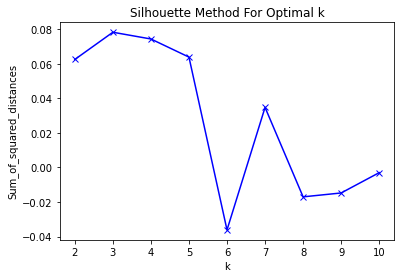

In [103]:
# for calculating number of K in clusters

from sklearn.metrics import silhouette_score

sil = []
kmax = 10
K = range(2, kmax+1)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in K:
    kmeans = KMeans(n_clusters = k).fit(data_transformed)
    labels = kmeans.labels_
    sil.append(silhouette_score(data_transformed, labels, metric = 'euclidean'))

plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Silhouette Method For Optimal k')
plt.show()

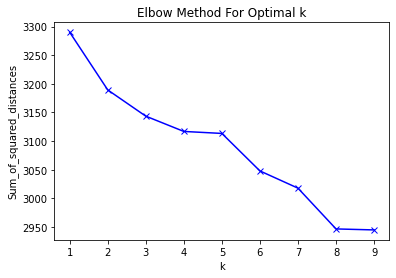

In [102]:
# source — https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

# another way for calculating number of K in clusters

# distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler


mas = MaxAbsScaler()
mas.fit(X)
data_transformed = mas.transform(X)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [10]:
freq = {}

for d in documents:
    Y = vectorizer.transform([d])
    prediction = model.predict(Y)
    if str(prediction) not in freq:
        freq[str(prediction)] = 1
    else:
        freq[str(prediction)] += 1

freq

{'[1]': 67, '[4]': 88, '[0]': 61, '[2]': 41, '[3]': 26}

In [11]:
tweets = []
nums = []
for num, d in enumerate(documents):
    Y = vectorizer.transform([d])
    prediction = model.predict(Y)
    if len(tweets) < 20 and prediction == [0]:
        if str([d])[2:-2] not in tweets:
            tweets.append(str([d])[2:-2])
            nums.append(num)

final_docs = []
for n in nums:
    final_docs.append(original_tweets[n])

for d in sorted(final_docs):
    print(d)
    print('- - - - - - - - -')

#COVID19 | Para evitar demissões durante a #pandemia, o @govbr vai pagar os salários dos trabalhadores de pequenas e médias empresas. A medida trouxe alívio para muita gente. 📺||| #coronavirus https://t.co/7M2oVH3N4l
- - - - - - - - -
#COVID19| @govbr comprará equipamentos para garantir segurança de policiais e agentes penitenciários, diz @MinEconomia. Além da União, medida visa atender órgãos de segurança pública dos estados e municípios durante a #pandemia➡️ https://t.co/ZJ0VyEb6oI #coronavirus

📷Ag.Brasil https://t.co/kYdTmNSjHA
- - - - - - - - -
@TeichNelson @govbr Seguindo o juramento de Hipócrates de salvar vidas
#FiqueEmCasa #COVID19
- - - - - - - - -
Boa noite,

Segue trecho da coletiva de imprensa no @Planalto sobre #Covid19 na qual participei junto ao ministro da saúde @TeichNelson. Assista mais no Youtube do @MCTIC: https://t.co/Lg0S2Pt4HS

Cotoveladas Espaciais 🇧🇷🇧🇷🇧🇷

@jairbolsonaro @minsaude @govbr @secomvc #IV https://t.co/BxVUGLVa32
- - - - - - - - -
Boa tarde,

Estão a